In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class Solver:
    def __init__(self, t0, tEnd, l):
        self.t0 = t0
        self.tEnd = tEnd
        self.l = l
        self.tList = np.linspace(self.t0, self.tEnd, 2**self.l)
        self.timeMeshes = [self.tList]
        self.dt = self.tList[1] - self.tList[0]
        self.PhiList = []


        
    def solve(self):
        for tList in self.timeMeshes:
            for t in tList:
                self.PhiList.append(self.Phi.copy())
                k1 = self.F(t, self.Phi)
                k2 = self.F(t+self.dt/2, self.Phi+k1*self.dt/2)
                k3 = self.F(t+self.dt/2, self.Phi+k2*self.dt/2)
                k4 = self.F(t+self.dt, self.Phi+k3*self.dt)

                self.Phi += self.dt/6*(k1 + 2*k2 + 2*k3 + k4)
            
        return self.tList, np.array(self.PhiList)
    
    


## Generalized Logistic

In [7]:
class GenLog(Solver):
    def __init__(self,mu,nu,k):
        super().__init__(t0=0,tEnd=15,l=10)
        
        self.Phi = np.array([3], dtype="float")
        self.mu = mu
        self.nu = nu
        self.k = k
        
        
    def F(self, t, Phi):
        phi0 = self.Phi[0]
        y1 = self.mu*phi0/self.nu * (1-(phi0/self.k)**self.nu)
        return np.array([y1])
    


         
            

In [8]:
def generalizedLogPlotter(ax,tList, PhiList, mu, nu, k):
    ax.plot(tList,
            PhiList,
            lw=3,
            label=r"$\mu$="+"{:0.2f}\n".format(mu)+r"$\nu$="+"{:0.2f}".format(nu))
    
    ax.set_xticks(np.linspace(0,15,5))
    ax.grid(10)
    ax.legend(loc=4,fontsize=12)
#     ax.set_xlabel("time", fontsize=15)
#     ax.set_ylabel("population", fontsize=15)
#     ax.set_title("Gompertz model\n"+"K="+str(k)+"\n"+"$\a$={:0.2f}".format(nu),
#                  fontsize=15)
#     ax.set_title("Gompert model\n"+r"$K$="+str(k)+r", $\nu$="+"{:0.2f}".format(nu),
#                  fontsize=15)

    
    

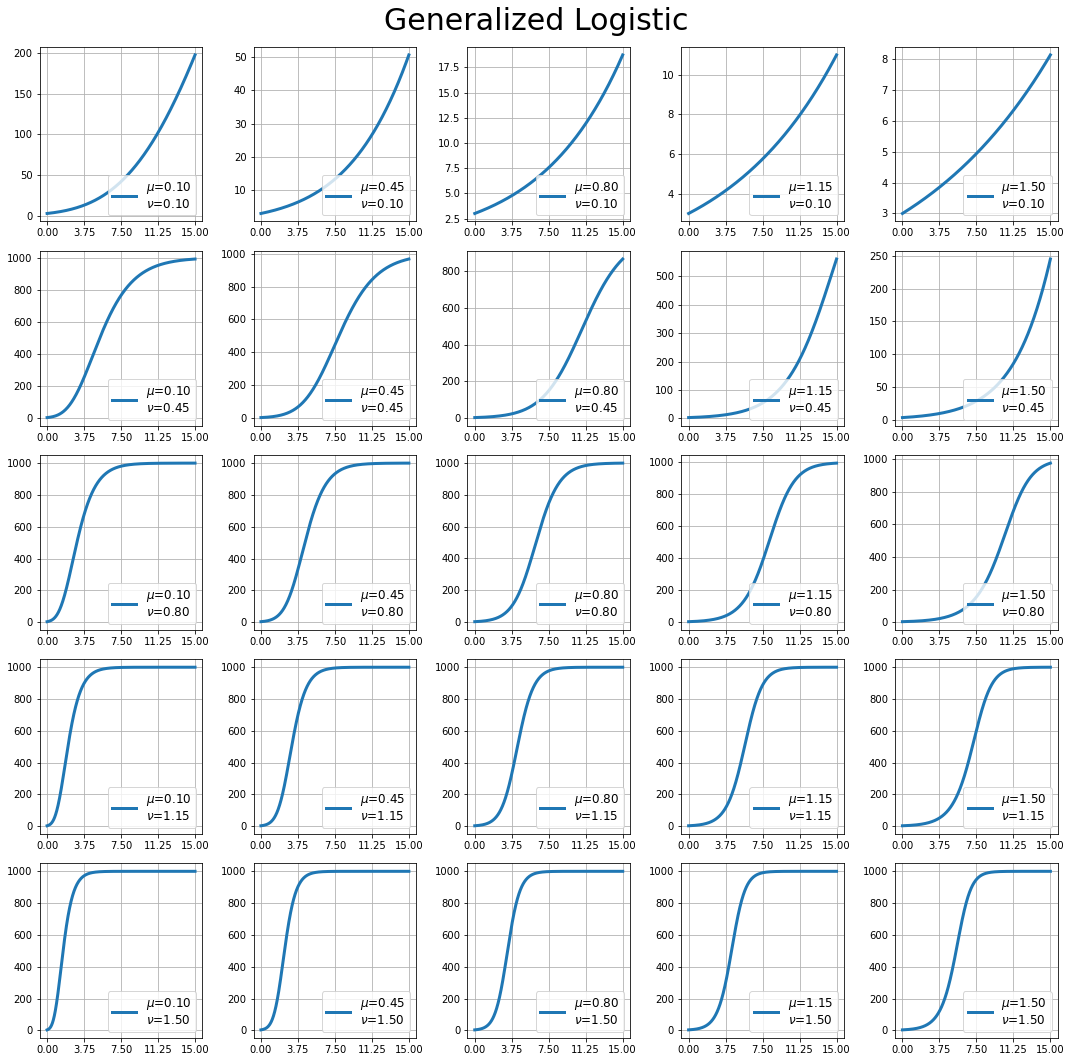

In [9]:
k = 1000
fig,ax = plt.subplots(5,5,figsize=(15,15))

muList = np.linspace(0.1,1.5,5)
nuList = np.linspace(0.1,1.5,5)

Mu,Nu = np.meshgrid(muList, nuList)


for i in range(5):
    for j in range(5):
        mu = Mu[i,j]
        nu = Nu[i,j]
        genLogSys = GenLog(nu, mu, k)
        tList, PhiList = genLogSys.solve()
        generalizedLogPlotter(ax[i,j],tList,PhiList,mu,nu,k)
        
        
    
_ = fig.suptitle("Generalized Logistic", fontsize=30)

fig.tight_layout(rect=[0, 0.0, 1, 0.99])

    

## Gompertz Model

In [10]:
class Gompertz(Solver):
    def __init__(self, mu, k):
        super().__init__(t0=0,tEnd=10,l=10)
        
        self.Phi = np.array([3], dtype="float")
        self.mu = mu
        self.k = k
        
        
    def F(self, t, Phi):
        phi0 = self.Phi[0]
        y1 = -self.mu * phi0 * np.log(phi0/self.k + 0.00001)
        return np.array([y1])
    


         

Text(0.5, 1.0, 'Gompertz model\nK=1000')

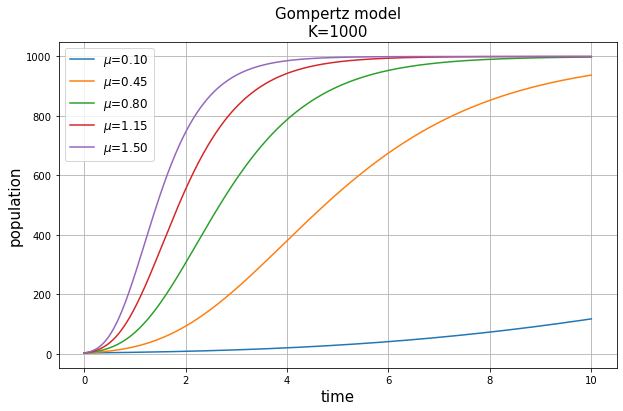

In [11]:
muList = np.linspace(0.1,1.5,5)
k = 1000
fig,ax = plt.subplots(figsize=(10,6))
for mu in muList:
    GompSys = Gompertz(mu, k)
    tList, PhiList = GompSys.solve()
    
    ax.plot(tList, PhiList, label=r"$\mu$="+"{:0.2f}".format(mu).format(mu))
    
ax.grid()
ax.legend(fontsize=12)
ax.set_xlabel("time", fontsize=15)
ax.set_ylabel("population", fontsize=15)
ax.set_title("Gompertz model\n"+"K="+str(k), fontsize=15)

    
    
    

## Solving with multiple time mesh

It is very common that in simulations we come up with a situation where at a certian time (lets say $t_0$) some function becomes non-zero. However there is a challenge in including such a behaviour in a simulation. That is because there is no guarantee that the time step will fall exactly on the time $t_0$. To overcome this problem, I have the following approach: Suppose that we want to simulate the following syste:

$$  \frac{d\psi}{dt} = - \lambda \psi + c_0 s(t-t_1) exp(-r(t-t_1))  $$

in which $s(t-t_0)$ is a step function. To simulate this system from $t_0$ until $t_{end}$ we need to have two meshes for time. One from $t_0$ to $t_1$ and the other one from $t_1$ to $t_{end}$.

So infact we will have two simulations (with the RK-4 method) and yet we need to write another function that manages these two seperate simulations and encapsulates them in a way that it looks like a single simulation from outside.

In [268]:
class InputedSystem(Solver):
    def __init__(self):
        self.t0 = 0
        self.tEnd = 30
        self.l = 9
        self.PhiList = []
        
#         self.alpha = 2
#         self.omega = 0.09
#         self.gamma = 0.04
#         self.mu = 0.4
#         self.k = 4
        
        self.alpha = 0
        self.omega = 0.5
        self.gamma = 0.5
        self.mu = 0.6
        self.k = 5
    
        self.eventsList = np.array([], dtype="float")
        self.timeMeshes = []
        self.dtList = []
        self.tList = []
        
        self.Phi = np.array([0.001,self.k], dtype="float")
        self.createTimeMesh()

        
        
    def F(self, t, Phi):
        N = Phi[0]
        K = Phi[1]
        y0 = -N*self.mu*np.log(N/K)
        y1 = -self.alpha*self.c(t)*K + self.omega*N - self.gamma*N**(2/3)*K
        return np.array([y0, y1])
    
    
    def createTimeMesh(self):
        t0 = self.t0
        for timePoint in self.eventsList:
            tList = np.linspace(t0,timePoint,2**self.l)
            self.timeMeshes.append(tList)
            self.dtList.append(tList[1]-tList[0])
            t0 = timePoint
            
        tList = np.linspace(t0,self.tEnd,2**self.l)
        self.timeMeshes.append(np.linspace(t0,self.tEnd,2**self.l))
        self.dtList.append(tList[1]-tList[0])
        
        for tList in self.timeMeshes:
            self.tList = np.concatenate((self.tList, tList))
        
        
    def c(self,t):
        cTotal = 0
        for eventTime in self.eventsList:
            cTotal += self.step(t, eventTime)*np.exp(-8*(t-eventTime))
            
        return cTotal
        
        
    def step(self, t, t0):
        if t<t0:
            return 0
        else:
            return 1
        
    def run(self):
        for i in range(self.eventsList.shape[0]+1):
            tList = self.timeMeshes[i]
            self.dt = self.dtList[i]
            self.solve(tList)
            
        return self.tList, np.array(self.PhiList)
        
    def solve(self, tList):
        for t in tList:
            self.PhiList.append(self.Phi.copy())
            k1 = self.F(t, self.Phi)
            k2 = self.F(t+self.dt/2, self.Phi+k1*self.dt/2)
            k3 = self.F(t+self.dt/2, self.Phi+k2*self.dt/2)
            k4 = self.F(t+self.dt, self.Phi+k3*self.dt)

            self.Phi += self.dt/6*(k1 + 2*k2 + 2*k3 + k4)
            
        
    



In [287]:
sys = InputedSystem()
tList, phiList = sys.run()
acceleration = (np.roll(phiList[:,0],-1) - phiList[:,0])/(sys.dtList)

Text(0, 0.5, 'K')

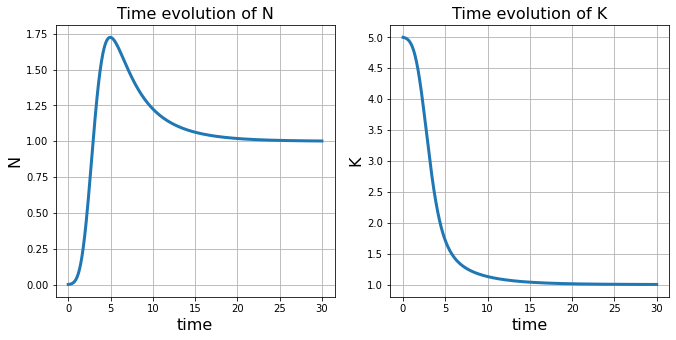

In [288]:
fig, ax = plt.subplots(1,2, figsize=(11,5))
ax[0].plot(tList, phiList[:,0], lw=3)
ax[0].grid()
ax[0].set_title("Time evolution of N", fontsize=16)
ax[0].set_xlabel("time", fontsize=16)
ax[0].set_ylabel("N", fontsize=16)
ax[1].plot(tList, phiList[:,1], lw=3)
ax[1].grid()
ax[1].set_title("Time evolution of K", fontsize=16)
ax[1].set_xlabel("time", fontsize=16)
ax[1].set_ylabel("K", fontsize=16)


Text(0, 0.5, '$\\frac{dN}{dt}$')

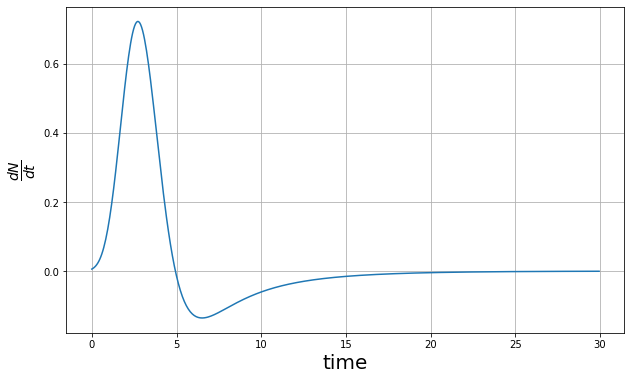

In [294]:
plt.figure(figsize=(10,6))
plt.plot(tList[:-1], acceleration[:-1])
plt.grid()
plt.xlabel("time", fontsize=20)
plt.ylabel(r"$\frac{dN}{dt}$", fontsize=20)

In [227]:
class StreamPlot:
    def __init__(self):
        self.mu = 1.5
        self.w = 1
        self.g = 0.6
        
        self.NList = np.linspace(0,5,100)
        self.KList = np.linspace(0,5,100)
        self.K, self.N = np.meshgrid(self.NList, self.KList)
        self.VN = -self.N*self.mu*np.log((self.N+0.0001)/(self.K+0.0001))
        self.VK = self.w*self.N - self.g*self.N**(2/3)*self.K
        

        self.starts = np.random.randn(10,2)+np.array([2,2])
        
    def plot(self):
        plt.streamplot(self.K, self.N, self.VK, self.VN, density=(1.3,0.8),
                       arrowsize=1.5, minlength=0.3,
                       integration_direction="forward")
        plt.plot(self.KList, self.NList, lw=4)
        plt.plot(self.KList, (self.KList * self.g/self.w)**3, lw=4)
        plt.plot([(self.w/self.g)**(3/2)],[(self.w/self.g)**(3/2)],'o',markersize=12)
        plt.xlim([0,5])
        plt.ylim([0,5])
        plt.xlabel("K", fontsize=16)
        plt.ylabel("N", fontsize=16)
        plt.title("phase diagram", fontsize=16)
        
        
        

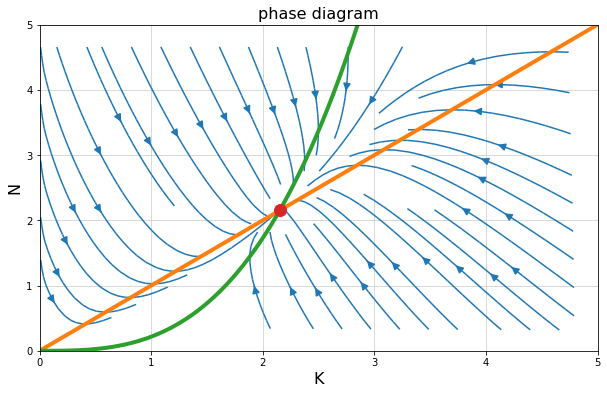

In [228]:
plt.figure(figsize=(10,6))
streamPlot = StreamPlot()
streamPlot.plot()
plt.grid(alpha=0.6)


In [275]:
np.roll([1,2,3],-1)

array([2, 3, 1])